In [1]:
!pip install seaborn

In [2]:
import torch as T
import pandas as pd
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from prior_profile import ClassificationNet

device = "cuda" if T.cuda.is_available() else "cpu"


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def next_batch(inputs, targets, batchSize):
    for i in range(0, inputs.shape[0], batchSize):
         yield (inputs[i:i + batchSize], targets[i:i + batchSize])

df_student = pd.read_csv("./dataset/merged_student_engagement_level.csv")

df_experiment =  df_student.copy()


df_experiment['engagement'] = df_experiment['engagement'].map(
    {'H': 2, 'M': 1, 'L': 0}
)

X = df_experiment.loc[:,["reviews", "a1", "a2", "a3", "gender", "grade"]].values
y = df_experiment.iloc[:, 4].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# For low ressouces
X_train = X_train[0:700]
y_train = y_train[0:700]

X_test = T.FloatTensor(X_test)
y_train = T.LongTensor(y_train)
y_test = T.LongTensor(y_test)

scaler = StandardScaler()

X_train = T.from_numpy(scaler.fit_transform(X_train)).float()
X_test = T.from_numpy(scaler.fit_transform(X_test)).float()

epochs = 50
BATCH_SIZE = 10
losses = []
model = ClassificationNet().to(device)
optimizer = T.optim.Adam(model.parameters(), lr=0.001)
criterion = T.nn.CrossEntropyLoss()
j = 0

for (batchX, batchY) in next_batch(X_train, y_train, BATCH_SIZE):
    (batchX, batchY) = (batchX, batchY.to(device))
    j += 1
    
    for i in range(epochs):
        i += 1
        
        y_pred = model(batchX)
        loss = criterion(y_pred, batchY.long())
        losses.append(loss)
        
        if j % 20 == 0:
            print(f'epoch: {i} -> batch: {j} -> loss: {loss}')
            
        optimizer.zero_grad()
        loss.backward()
        T.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()



epoch: 1 -> batch: 20 -> loss: 1.3460524082183838
epoch: 2 -> batch: 20 -> loss: 1.3335330486297607
epoch: 3 -> batch: 20 -> loss: 1.3103610277175903
epoch: 4 -> batch: 20 -> loss: 1.279278039932251
epoch: 5 -> batch: 20 -> loss: 1.2427157163619995
epoch: 6 -> batch: 20 -> loss: 1.2027432918548584
epoch: 7 -> batch: 20 -> loss: 1.161049723625183
epoch: 8 -> batch: 20 -> loss: 1.1189568042755127
epoch: 9 -> batch: 20 -> loss: 1.0774507522583008
epoch: 10 -> batch: 20 -> loss: 1.03731369972229
epoch: 11 -> batch: 20 -> loss: 0.9993802309036255
epoch: 12 -> batch: 20 -> loss: 0.9632631540298462
epoch: 13 -> batch: 20 -> loss: 0.9290496110916138
epoch: 14 -> batch: 20 -> loss: 0.8967069387435913
epoch: 15 -> batch: 20 -> loss: 0.8660290837287903
epoch: 16 -> batch: 20 -> loss: 0.8370046615600586
epoch: 17 -> batch: 20 -> loss: 0.8094987869262695
epoch: 18 -> batch: 20 -> loss: 0.7833712100982666
epoch: 19 -> batch: 20 -> loss: 0.7584953904151917
epoch: 20 -> batch: 20 -> loss: 0.7347597479

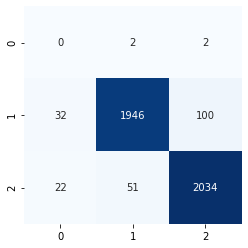

In [3]:
with T.no_grad():
    model.eval()
    pred = model(X_test)
    _, pr = T.max(pred, 1)
    
    '''
        Engagement level 
        'High': 2, 'Medium': 1, 'Low': 0
    '''
    conf_mat = confusion_matrix(pr.tolist(), y_test.tolist())
    sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

T.save(model, "./models/PriorProfile")